In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/prostate.h5ad'

adata = sc.read_h5ad(results_file)
# subset to epithelial
adata = adata[adata.obs['celltype'].isin(['BE','HE','CE','LE-KLK3','LE-KLK4'])]
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


View of AnnData object with n_obs × n_vars = 10587 × 1487 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

drawing single-cell graph using layout 'fa'


Trying to set attribute `.uns` of view, making a copy.


    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:07)


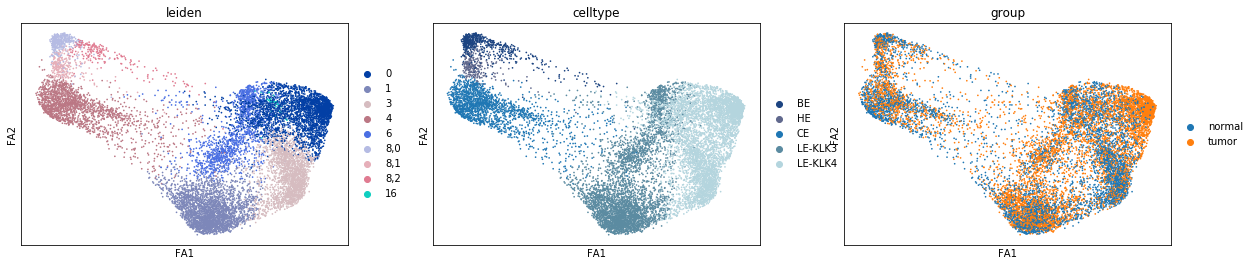

In [2]:
# draw the graph
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['leiden', 'celltype', 'group'])

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9834285  0.96512616 0.95392317 0.9297928  0.92073804
     0.9113749  0.8980274  0.89170784 0.8896336  0.87723273 0.8753854
     0.86839944 0.86277723 0.8578962 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:07)


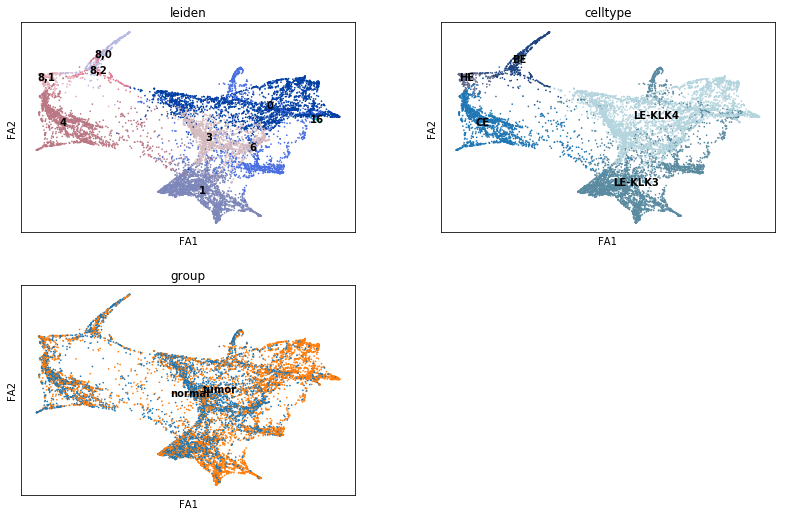

In [3]:
# denoise the graph
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['leiden', 'celltype', 'group'], legend_loc='on data', ncols = 2)

In [4]:
# simple, coarse-grained visualization,
sc.tl.paga(adata)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


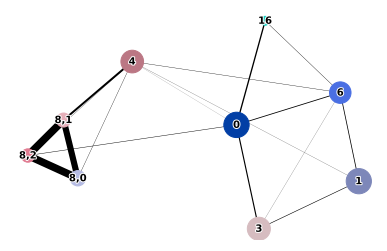

--> added 'pos', the PAGA positions (adata.uns['paga'])


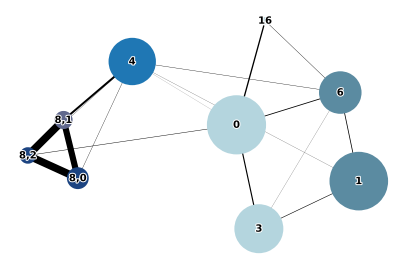

--> added 'pos', the PAGA positions (adata.uns['paga'])


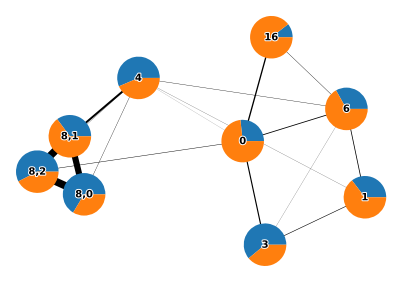

In [5]:
sc.pl.paga(adata, color=['leiden'], frameon = False, node_size_scale = 3, edge_width_scale = 1, fontoutline = 2)
sc.pl.paga(adata, color=['celltype'], frameon = False, node_size_scale = 3, edge_width_scale = 1, fontoutline = 2)
sc.pl.paga(adata, color=['group'], frameon = False, node_size_scale = 3, node_size_power = 0, edge_width_scale = 1, fontoutline = 2)

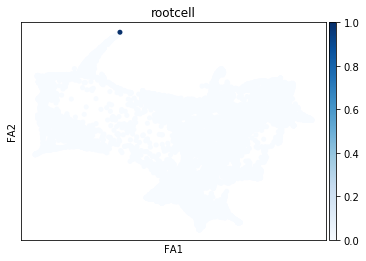

In [6]:
# find the root cell in cluster 8 (BE),  simple because it's the first cell at the top
rootcell = adata.obs.index[pd.DataFrame(adata.obsm['X_draw_graph_fa'])[1].idxmax()]
adata.obs['rootcell'] = 0
adata.obs['rootcell'][rootcell] = 1

sc.pl.draw_graph(adata,color='rootcell', color_map='Blues', size = 100)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


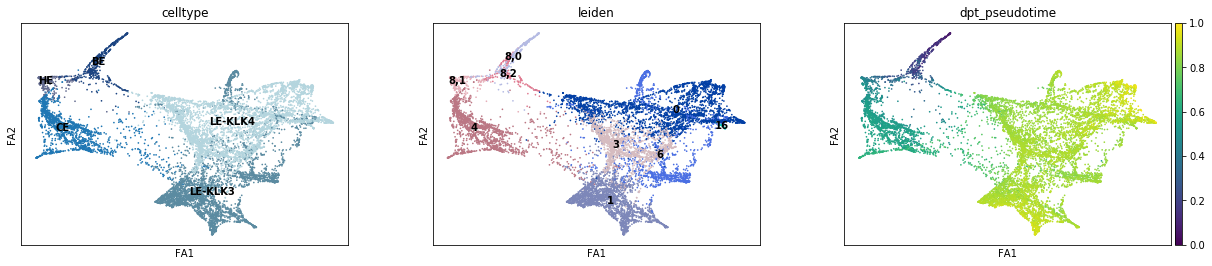

In [7]:
# run diffusion pseudotime
adata.uns['iroot'] = pd.DataFrame(adata.obsm['X_draw_graph_fa'])[1].idxmax()
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['celltype', 'leiden', 'dpt_pseudotime'], legend_loc='on data')

In [8]:
import palantir
# run palantir pseudotime
ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
pr_res = palantir.core.run_palantir(ms_data, rootcell, num_waypoints=500, knn=30)

# add the pseudotime values to addata object
adata.obs['palantir_pseudotime'] = pr_res.pseudotime

Sampling and flocking waypoints...
Time for determining waypoints: 0.005524154504140218 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.34642170667648314 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9755
Correlation at iteration 2: 0.9997
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


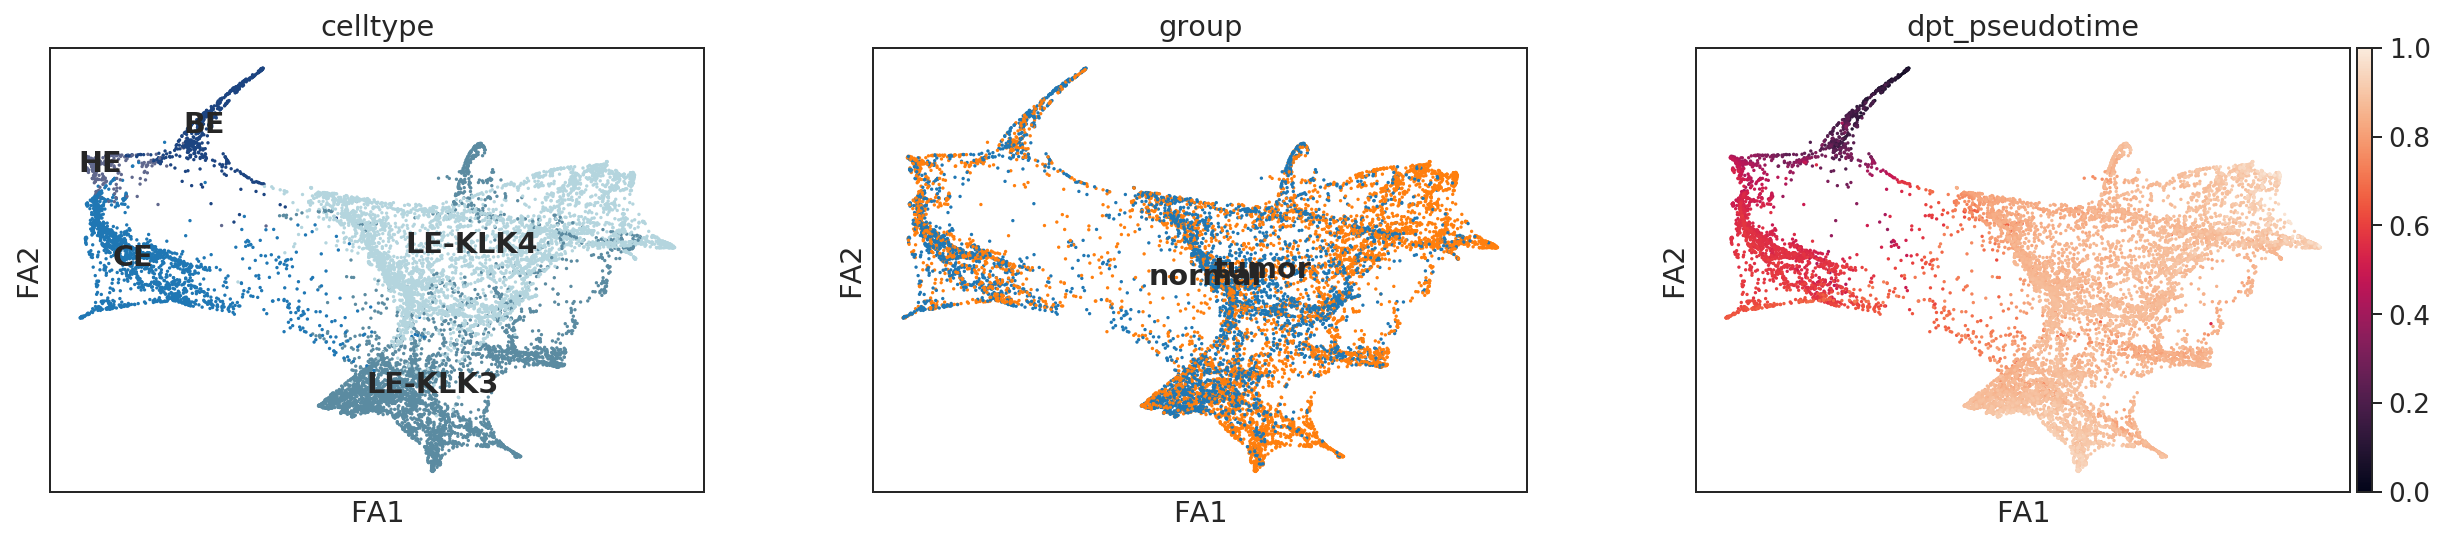

In [9]:
sc.pl.draw_graph(adata, color=['celltype', 'group', 'dpt_pseudotime'], legend_loc='on data')
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.draw_graph(adata, color=['celltype',  'group','palantir_pseudotime'], legend_loc='on data', save = '/epi_palantir_pseudotime.pdf')

In [10]:
sc.pl.umap(adata, color=['celltype','group','palantir_pseudotime'], color_map = 'inferno', legend_loc='on data', save = '/epi_palantir_pseudotime_umap.pdf')

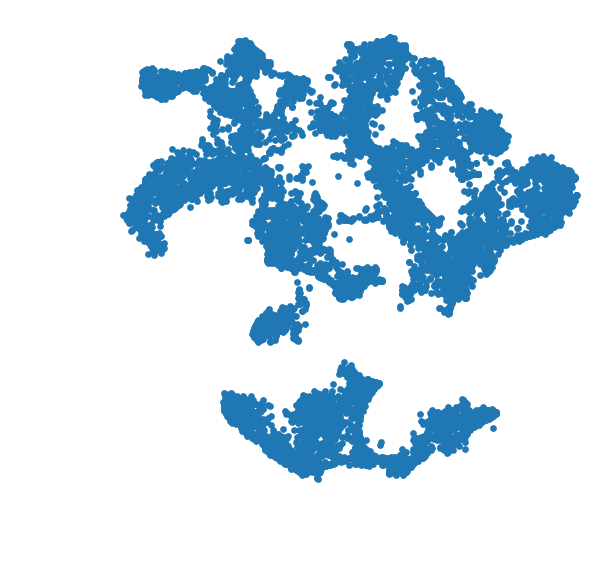

In [11]:
tsne = palantir.utils.run_tsne(ms_data)
fig, ax = palantir.plot.plot_tsne(tsne)

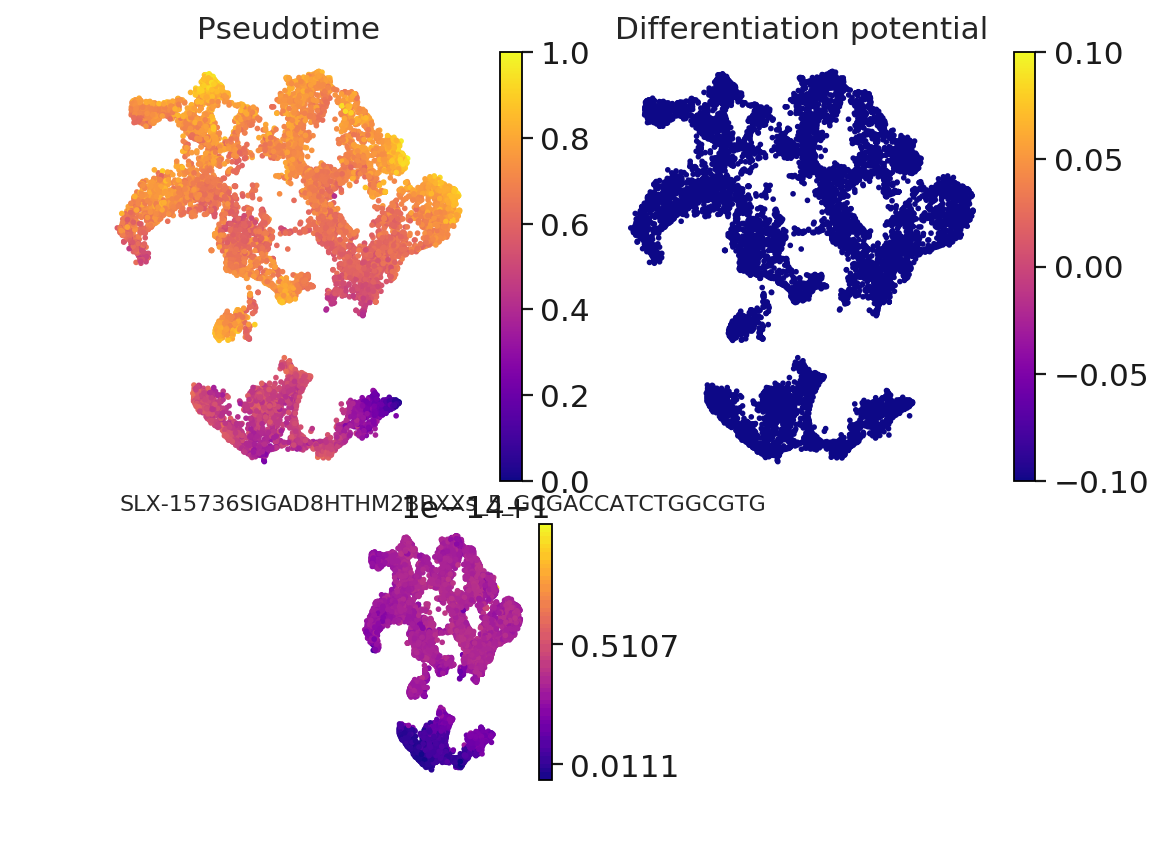

In [12]:
palantir.plot.plot_palantir_results(pr_res, tsne)

In [ ]:
adata.write('out/prostate_epi_paga.h5ad', compression = 'gzip')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:19)


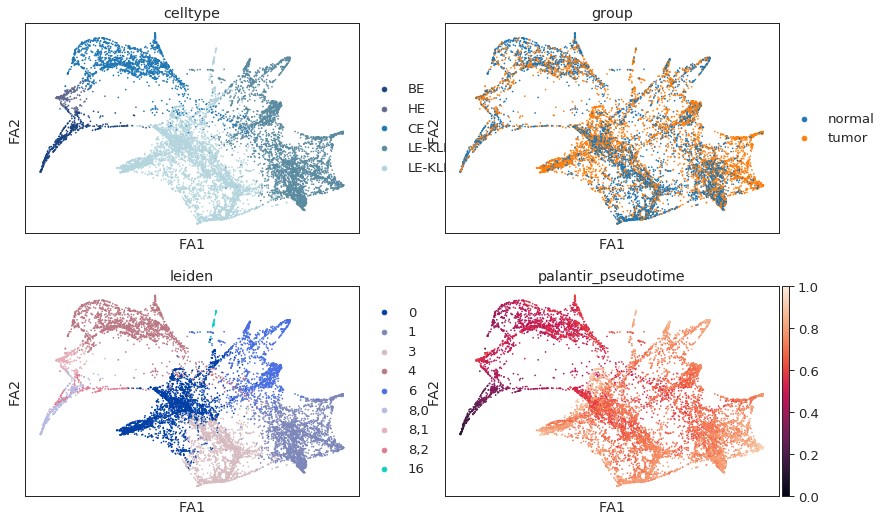

In [24]:
adata2 = adata.copy()
sc.tl.draw_graph(adata2, init_pos='paga')
sc.pl.draw_graph(adata2, color=['celltype', 'group', 'leiden', 'palantir_pseudotime'], ncols = 2)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/prostate.h5ad'

adata = sc.read_h5ad(results_file)
# subset to epithelial
adata = adata[(adata.obs['group'] == 'normal') & (adata.obs['celltype'].isin(['BE','CE','HE','LE-KLK3','LE-KLK4']))]
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


View of AnnData object with n_obs × n_vars = 4431 × 1487 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

drawing single-cell graph using layout 'fa'


Trying to set attribute `.uns` of view, making a copy.


    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:27)


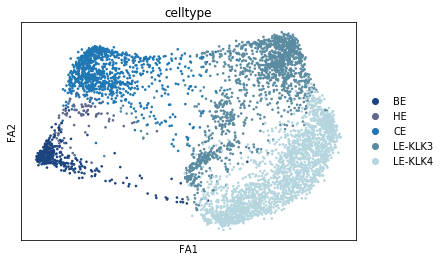

In [2]:
# draw the graph
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['celltype'])

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.98695636  0.9721057   0.9641812   0.9507297   0.9364404
      0.9340733   0.9265138   0.9171938   0.91548425  0.91169375  0.90568626
      0.9038082   0.90040433 -0.90569633]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:27)


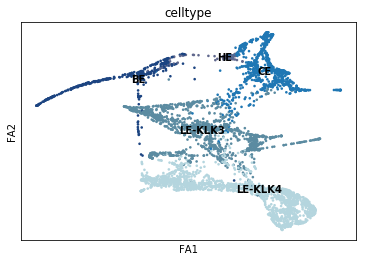

In [3]:
# denoise the graph
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['celltype'], legend_loc='on data', ncols = 2)

In [4]:
# simple, coarse-grained visualization,
sc.tl.paga(adata, groups='celltype')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


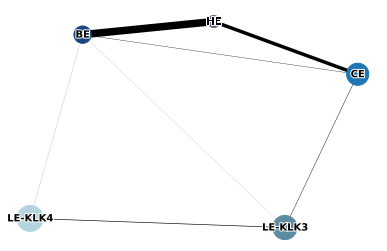

In [5]:
sc.pl.paga(adata, color=['celltype'], frameon = False, node_size_scale = 3, edge_width_scale = 1, fontoutline = 2)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


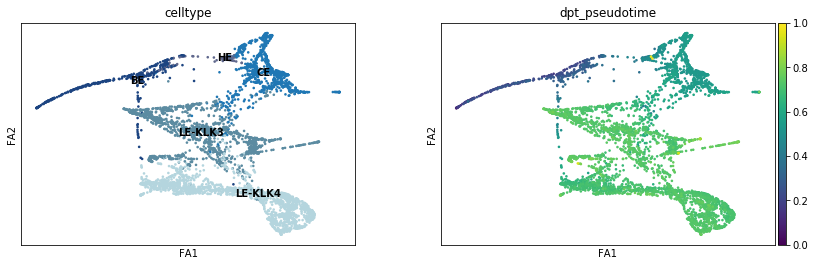

In [6]:
# run diffusion pseudotime
# set cluster 8 as the root
# adata.uns['iroot'] = np.flatnonzero(adata.obs['celltype']  == 'BE')[0]
adata.uns['iroot'] = pd.DataFrame(adata.obsm['X_draw_graph_fa'])[0].idxmin()
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['celltype', 'dpt_pseudotime'], legend_loc='on data')

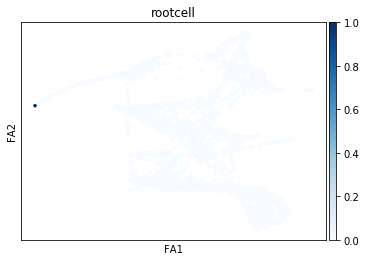

In [7]:
# use the same root cell for palantir
# rootcell = adata.obs['celltype'][adata.obs['celltype'].isin(['BE'])].index[0]
rootcell = adata.obs.index[pd.DataFrame(adata.obsm['X_draw_graph_fa'])[0].idxmin()]
adata.obs['rootcell'] = 0
adata.obs['rootcell'][rootcell] = 1

sc.pl.draw_graph(adata,color='rootcell',color_map='Blues', size = 50)

In [8]:
import palantir
# run palantir pseudotime
ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
pr_res = palantir.core.run_palantir(ms_data, rootcell, num_waypoints=500, knn=30)

# add the pseudotime values to addata object
adata.obs['palantir_pseudotime'] = pr_res.pseudotime

Sampling and flocking waypoints...
Time for determining waypoints: 0.002391358216603597 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.25138999621073405 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9912
Correlation at iteration 2: 0.9996
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


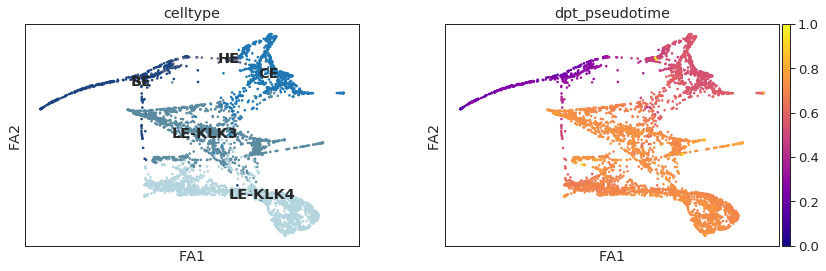

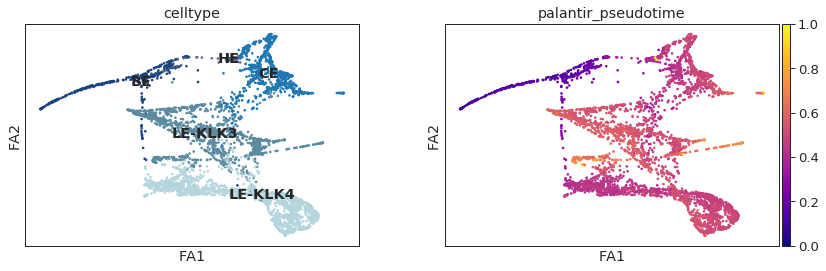

In [14]:
sc.pl.draw_graph(adata, color=['celltype', 'dpt_pseudotime'], legend_loc='on data', color_map = 'plasma')
sc.pl.draw_graph(adata, color=['celltype', 'palantir_pseudotime'], legend_loc='on data', color_map = 'plasma')

--> added 'pos', the PAGA positions (adata.uns['paga'])


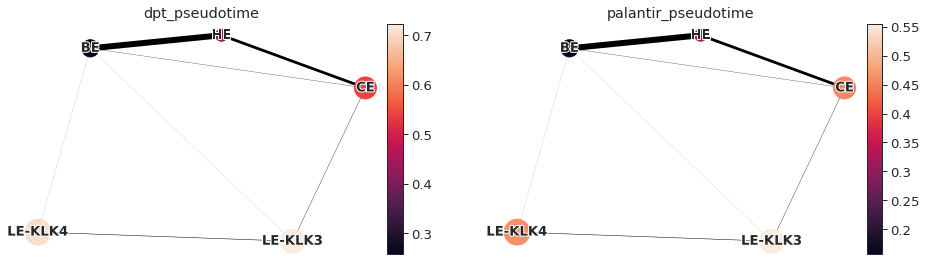

In [10]:
sc.pl.paga(adata, color=['dpt_pseudotime', 'palantir_pseudotime'], frameon = False, node_size_scale = 3, edge_width_scale = 1, fontoutline = 2)